In [13]:
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt
from lib import diptrap
from scipy.optimize import curve_fit

In [14]:
cons_meas = 50
reps = 1
N_atoms_s = [200,200]

def get_pseudo_data(rate__):

    data_all_ = np.zeros([cons_meas, reps, len(N_atoms_s)])
    bins = np.linspace(0,1,cons_meas+1)

    for i, N_at in enumerate(N_atoms_s):
        for ii in range(reps):
            dat_aus = plt.hist(scs.expon(scale=1/(cons_meas*rate__)).rvs(size=N_at), bins=bins)
            data_all_[:, ii, i] = dat_aus[0]
    plt.close()
    return data_all_

def MLE_exp_rate(vector, delta_t_):
    mean_k = 0
    for i, value in enumerate(vector):
        mean_k += i*value
    #rate =  1/delta_t_ * np.log(sum(vector)/mean_k+1)
    rate = - 1/delta_t_ * np.log(1-1/(1+mean_k/sum(vector)))

    return rate

In [15]:

rates_s = np.linspace(0.01, 0.3, 10)

def get_both_rates():
    rates_MLE_s = []
    drates_MLE_s = []
    rates_ms_s = []
    drates_ms_s = []
    N_atoms_s = [200,200]

    for rate_ in rates_s:
        data_all_ = get_pseudo_data(rate__=rate_)

        rates_MLE = []
        drates_MLE = []

        rates_ms = []
        drates_ms = []

        def exponential(rate, t):
            return rate*np.e**(-rate*t)

        x = np.linspace(0, cons_meas*1, cons_meas)

        for power in range(len(N_atoms_s)):
            
            def dev_std():
                a = []
                for i in range(cons_meas):
                    if np.std(data_all_[i, :, power]) == 0:
                        a.append(0.1)
                    else:
                        a.append(np.std(data_all_[i, :, power]))
                return np.array(a)

            rates = []
            for rep in range(reps):
                rates.append(MLE_exp_rate(data_all_[:, rep, power], 1))
            rates_MLE.append(np.mean(rates))
            drates_MLE.append(np.std(rates))
            
            #result = min_squared_rates(np.mean(data_all[:, :, power], axis=1), np.std(data_all[:, :, power], axis=1), delay_cons_exp, p0=[N_atoms_means[power],0.14])
            
            def exponential_(t, rate, A):
                return A*np.e**(-rate*t)

            result, cov = curve_fit(exponential_, np.linspace(0, 49, 50), np.mean(data_all_[:, :, power], axis=1), p0=[0.13, 20])
            #print(dev_std())
            rates_ms.append(result[0])

            y = exponential(np.mean(rates), x) * N_atoms_s[power]

        #    plt.plot(x, data_all[:,8,power], marker="o", linestyle="-", label="power = "+names[power]+" mW")
        #for power in range(len(N_atoms_s)):#[2,6,10]:
        #    plt.errorbar(x, np.mean(data_all_[:,:,power], axis=1), np.std(data_all_[:,:,power], axis=1), marker="o", alpha=0.6, linestyle="-", label="N = %d"%N_atoms_s[power])
        #    plt.plot(x,y, c="black")

        #print("MLE: ")
        #print(" - ", np.mean(rates_MLE), "+-", np.std(rates_MLE))

        #print("curve_fit: ")
        #print(" - ", np.mean(rates_ms), "+-", np.std(rates_ms))
        if len(N_atoms_s) == 1:
            std_MLE = drates_MLE[0]
            std_ms = np.sqrt(cov[0,0])
        else:
            std_MLE = np.std(rates_MLE)
            std_ms = np.std(rates_ms)
        
        rates_MLE_s.append(np.mean(rates_MLE))
        drates_MLE_s.append(std_MLE)
        rates_ms_s.append(np.mean(rates_ms))
        drates_ms_s.append(std_ms)

    return rates_MLE_s, drates_MLE_s, rates_ms_s, drates_ms_s

In [16]:
stats = 100
means_ms = []
means_MLE = []
stds_ms = []
stds_MLE = []
for _ in range(stats):
    rates_MLE_s, drates_MLE_s, rates_ms_s, drates_ms_s = get_both_rates()
    means_MLE.append(rates_MLE_s)
    stds_MLE.append(drates_MLE_s)
    means_ms.append(rates_ms_s)
    stds_ms.append(drates_ms_s)

rates_ms_s = np.mean(np.array(means_ms), axis=0)
rates_MLE_s = np.mean(np.array(means_MLE), axis=0)
drates_ms_s = np.mean(np.array(stds_ms), axis=0)
drates_MLE_s = np.mean(np.array(stds_MLE), axis=0)

NameError: name 'data_all' is not defined

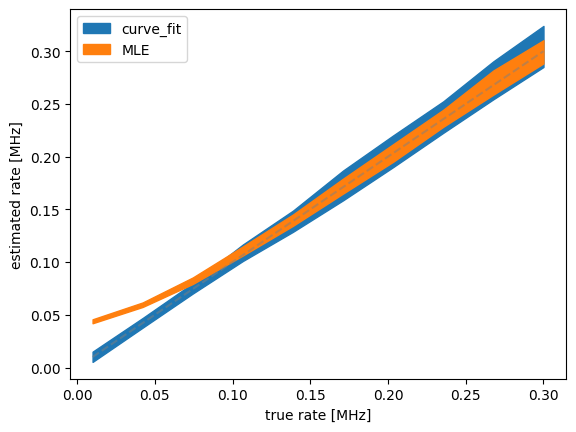

In [ ]:

plt.fill_between(rates_s, np.array(rates_ms_s)-np.array(drates_ms_s),  np.array(rates_ms_s)+np.array(drates_ms_s),color="tab:blue", label="curve_fit")
plt.fill_between(rates_s, np.array(rates_MLE_s)-np.array(drates_MLE_s),  np.array(rates_MLE_s)+np.array(drates_MLE_s),color="tab:orange",label="MLE")
    #plt.errorbar(rates_s, rates_ms_s, drates_ms_s, ls="", marker="o", label="curve fit")
    #plt.errorbar(rates_s, rates_MLE_s, drates_MLE_s,ls="", marker="o", label="MLE")
plt.plot(rates_s,rates_s, c="grey", alpha=0.5, ls="--")

plt.legend()
plt.xlabel("true rate [MHz]")
plt.ylabel("estimated rate [MHz]")

plt.show()